# Recommender System Competition

In [1]:
LOAD_MODELS = False

## Importing the repo

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("token")

!git clone https://{token}@github.com/Benedart/RecSys-2022-Challenge-Polimi.git

Cloning into 'RecSys-2022-Challenge-Polimi'...
remote: Enumerating objects: 659, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 659 (delta 20), reused 34 (delta 11), pack-reused 615
Receiving objects: 100% (659/659), 1.10 GiB | 44.04 MiB/s, done.
Resolving deltas: 100% (286/286), done.
Updating files: 100% (205/205), done.


In [3]:
import os

os.chdir( "./RecSys-2022-Challenge-Polimi")

### Compiling Cython files

In [4]:
!python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:746:
/opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In function ‘__

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps
import csv
from tqdm import tqdm
import math

from Recommenders.Recommender_import_list import *

# Data Import
#### Importing URM and ICM

In [6]:
URM_all = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/interactions_and_impressions.csv")
ICM_type = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_type.csv")
ICM_length = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_length.csv")

ICM_all = pd.concat([ICM_type, ICM_length]).sort_values(by='item_id')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
URM_all.head(5)

,UserID,ItemID,Impressions,Data
0,0,11,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1
1,0,21,NaN,0
2,0,21,NaN,0
3,0,21,"20,21,22,23,24,25,26,27,28,29",0
4,0,21,NaN,1


In [8]:
print("Items with type are {}".format(len(ICM_type)))
print("Items with length are {}".format(len(ICM_length)))
print("Items in the urm are {}".format(len(URM_all["ItemID"].unique())))

Items with type are 23091
Items with length are 23091
Items in the urm are 24507


# Preprocessing
#### Let's remove items that don't appear in the urm

In [9]:
users_URM = pd.DataFrame({"UserID": URM_all["UserID"].unique()})
users_URM.head(15)

,UserID
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [10]:
items_URM = pd.DataFrame({"item_id": URM_all["ItemID"].unique()})
items_URM

,item_id
0,11
1,21
2,22
3,24
4,44
...,...
24502,19714
24503,19075
24504,20006
24505,20177


In [11]:
all_items_ICM = pd.DataFrame({"item_id": ICM_all["item_id"].unique()})
all_items_ICM

,item_id
0,0
1,1
2,2
3,3
4,4
...,...
23086,27963
23087,27964
23088,27965
23089,27966


In [12]:
relevant_ICM_items = items_URM.merge(all_items_ICM, on="item_id")
relevant_ICM_items

,item_id
0,11
1,21
2,22
3,44
4,54
...,...
19625,13608
19626,21627
19627,19714
19628,20006


In [13]:
relevant_ICM = relevant_ICM_items.merge(ICM_all, on="item_id", how="left")
relevant_ICM  # these are the only features we want to care about

,item_id,feature_id,data
0,11,0,1
1,11,1,1
2,21,4,1
3,21,0,27
4,22,2,1
...,...,...,...
39255,19714,0,3
39256,20006,3,1
39257,20006,0,1
39258,20177,0,3


In [14]:
mapped_id, original_id = pd.factorize(URM_all["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)
print("Unique UserID in the URM are {}".format(len(original_id)))

mapped_id, original_id = pd.factorize(URM_all["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

feature_original_ID_to_index = pd.Series({
    0: 5,
    1: 0,
    2: 2,
    3: 3,
    7: 1,
    4: 4
}, index = [0, 1, 2, 3, 4, 7]) # feature id mapping

print("Unique FeatureID in the URM are {}".format(len(feature_original_ID_to_index)))

URM_all["UserID"] = URM_all["UserID"].map(user_original_ID_to_index)
URM_all["ItemID"] = URM_all["ItemID"].map(item_original_ID_to_index)
relevant_ICM["item_id"] = relevant_ICM["item_id"].map(item_original_ID_to_index)
relevant_ICM["feature_id"] = relevant_ICM["feature_id"].map(feature_original_ID_to_index)

Unique UserID in the URM are 41629
Unique FeatureID in the URM are 6


In [15]:
URM_all

,UserID,ItemID,Impressions,Data
0,0,0,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1
1,0,1,NaN,0
2,0,1,NaN,0
3,0,1,"20,21,22,23,24,25,26,27,28,29",0
4,0,1,NaN,1
...,...,...,...,...
5826501,41628,3700,NaN,0
5826502,41628,12694,NaN,1
5826503,41628,15132,NaN,1
5826504,41628,18128,NaN,0


In [16]:
relevant_ICM

,item_id,feature_id,data
0,0,5,1
1,0,0,1
2,1,4,1
3,1,5,27
4,2,2,1
...,...,...,...
39255,24502,5,3
39256,24504,3,1
39257,24504,5,1
39258,24505,5,3


In [17]:
ICM_all = relevant_ICM
ICM_all

,item_id,feature_id,data
0,0,5,1
1,0,0,1
2,1,4,1
3,1,5,27
4,2,2,1
...,...,...,...
39255,24502,5,3
39256,24504,3,1
39257,24504,5,1
39258,24505,5,3


---------

## Define User-Items to bonus/malus

In [18]:
def subtract_dfs(df1, df2):
    result = pd.merge(df1, df2, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    return result

In [19]:
def get_bonus_fakemalus_realmalus(u):
    DF_Clicked = u[u["Data"] == 1].drop(["Impressions"], axis=1)
    DF_Clicked = DF_Clicked.groupby(['UserID', 'ItemID'], as_index=False).count()
    DF_Clicked.rename(inplace=True, columns={"Data": "Clicked"})
    DF_Watched = u[u["Data"] == 0].drop(["Impressions"], axis=1)
    DF_Watched = DF_Watched.groupby(['UserID', 'ItemID'], as_index=False).count()
    DF_Watched.rename(inplace=True, columns={"Data": "Watched"})
    
    # find bonus: interactiors that are both watched and clicked
    comparison_df = DF_Watched.merge(DF_Clicked, on=["UserID", "ItemID"])
    comparison_df = comparison_df.drop(["Clicked", "Watched"], axis=1)
    bonus = np.array((comparison_df.UserID, comparison_df.ItemID))
    
    # fake malus: interactions that have been only watched
    Watched_once_df = DF_Watched[DF_Watched["Watched"]==1]
    Fake_Malus_df = subtract_dfs(Watched_once_df.drop(["Watched"], axis=1), DF_Clicked.drop(["Clicked"], axis=1))
    fake_malus = np.array((Fake_Malus_df.UserID, Fake_Malus_df.ItemID))
    
    # real malus: interactions that have been only clicked
    Clicked_once_df = DF_Clicked[DF_Clicked["Clicked"]==1]
    Real_Malus_df = subtract_dfs(Clicked_once_df.drop(["Clicked"], axis=1), DF_Watched.drop(["Watched"], axis=1))
    real_malus = np.array((Real_Malus_df.UserID, Real_Malus_df.ItemID))

    return bonus, fake_malus, real_malus

In [20]:
both_watched_and_clicked, only_watched_once, only_clicked_once = get_bonus_fakemalus_realmalus(URM_all)
both_watched_and_clicked, only_watched_once, only_clicked_once

(array([[    0,     0,     0, ..., 41617, 41624, 41624],
        [    1,    13,    15, ...,   487,  1384,  5463]]),
 array([[    0,     0,     0, ..., 41628, 41628, 41628],
        [    6,    11,    25, ..., 18128, 19540, 20960]]),
 array([[    0,     0,     0, ..., 41628, 41628, 41628],
        [    0,     3,     4, ..., 17163, 18725, 22724]]))

In [21]:
def get_modified_urm(urm_original, bonus_amount, bonus_interactions):     # malus negativi!!!!
    bonus_length = bonus_interactions.shape[1]
       
        
    urm_copy = urm_original.copy()
    
    for i in range(0, bonus_length):
        x = urm_copy[bonus_interactions[0][i], bonus_interactions[1][i]]
        if (x!=0): urm_copy[bonus_interactions[0][i], bonus_interactions[1][i]] += bonus_amount
            
    
    return urm_copy

---------

## Creating the matrices

In [22]:
URM_all_binary = URM_all.drop(["Impressions", "Data"], axis=1).drop_duplicates()

In [23]:
URM_all_binary["Rating"] = 1.0
URM_all_binary

,UserID,ItemID,Rating
0,0,0,1.0
1,0,1,1.0
13,0,2,1.0
28,0,3,1.0
29,0,4,1.0
...,...,...,...
5826501,41628,3700,1.0
5826502,41628,12694,1.0
5826503,41628,15132,1.0
5826504,41628,18128,1.0


In [24]:
ICM_all["feature_id"].unique()

array([5, 0, 4, 2, 3, 1])

In [25]:
n_users = len(user_original_ID_to_index)
n_items = len(item_original_ID_to_index)
n_features = len(feature_original_ID_to_index)

print("Number of users is {}".format(n_users))
print("Number of items is {}".format(n_items))
print("Number of features is {}".format(n_features))

from sklearn.model_selection import train_test_split
seed = 42

(user_ids_training, user_ids_validation,
 item_ids_training, item_ids_validation,
 ratings_training, ratings_validation) = train_test_split(URM_all_binary.UserID,
                                                        URM_all_binary.ItemID,
                                                        URM_all_binary.Rating,
                                                        test_size=0.15,
                                                        shuffle=True,
                                                        random_state=seed)

urm_train = sps.csr_matrix((ratings_training, (user_ids_training, item_ids_training)),
                           shape = (n_users, n_items))

urm_validation = sps.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)),
                           shape = (n_users, n_items))

urm_all = sps.csr_matrix((URM_all_binary.Rating, (URM_all_binary.UserID, URM_all_binary.ItemID)),
                           shape = (n_users, n_items))

icm_all = sps.csr_matrix((np.ones(len(ICM_all["item_id"].values)), 
                          (ICM_all["item_id"].values, ICM_all["feature_id"].values)),
                        shape = (n_items, 6))

icm_all.data = np.ones_like(icm_all.data)

icm_all = sps.csr_matrix(icm_all)
features_per_item = np.ediff1d(icm_all.indptr)

icm_all = sps.csc_matrix(icm_all)
items_per_feature = np.ediff1d(icm_all.indptr)

icm_all = sps.csr_matrix(icm_all)

urm_train, urm_validation, urm_all, icm_all

Number of users is 41629
Number of items is 24507
Number of features is 6


(<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 1321444 stored elements in Compressed Sparse Row format>,
 <41629x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 233196 stored elements in Compressed Sparse Row format>,
 <41629x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 1554640 stored elements in Compressed Sparse Row format>,
 <24507x6 sparse matrix of type '<class 'numpy.float64'>'
 	with 39260 stored elements in Compressed Sparse Row format>)

In [26]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(urm_train, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(urm_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 976 ( 2.3%) Users that have less than 1 test interactions


--------------

# Models
## Parameters

### Slim Elastic + Stacking + URM Bonus

In [27]:
slim_both_bonus = 0.25
slim_only_watched_once_malus = -0.1   
slim_only_clicked_once_malus = -0.1   

In [28]:
slim_urm_all = get_modified_urm(urm_all, slim_both_bonus, both_watched_and_clicked)
slim_urm_all = get_modified_urm(slim_urm_all, slim_only_watched_once_malus, only_watched_once)
slim_urm_all = get_modified_urm(slim_urm_all, slim_only_clicked_once_malus, only_clicked_once)

slim_urm_train = get_modified_urm(urm_train, slim_both_bonus, both_watched_and_clicked)
slim_urm_train = get_modified_urm(slim_urm_train, slim_only_watched_once_malus, only_watched_once)
slim_urm_train = get_modified_urm(slim_urm_train, slim_only_clicked_once_malus, only_clicked_once)

In [29]:
urm_train[0,1], slim_urm_train[0,1]

(1.0, 1.25)

In [30]:
urm_train[0,6], slim_urm_train[0,6]

(1.0, 0.9)

In [31]:
SLIM_Elastic_params = {
    'topK': 2492,
    'l1_ratio': 0.09122038444743771,
    'alpha': 0.00031614482201457075
}

#### Stacking

In [32]:
ICM_Type = ICM_all[ICM_all["feature_id"] != 5] # togliamo la length
icm_type = sps.csr_matrix((ICM_Type.data, (ICM_Type.feature_id, ICM_Type.item_id)),
                         shape = (5, n_items))

In [33]:
icm_type

<5x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 19630 stored elements in Compressed Sparse Row format>

In [34]:
stack_alpha = 0.7896376793234108
stacked_urm_all = sps.vstack([slim_urm_all.multiply(stack_alpha), icm_type.multiply(1 - stack_alpha)]) # stack su quella con bonus
stacked_urm_train = sps.vstack([slim_urm_train.multiply(stack_alpha), icm_type.multiply(1 - stack_alpha)]) # stack su quella con bonus
stacked_urm_all, stacked_urm_train

(<41634x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 1574270 stored elements in Compressed Sparse Row format>,
 <41634x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 1341074 stored elements in Compressed Sparse Row format>)

----------

### RP3Beta

In [35]:
rp3_both_bonus = 0.75

In [36]:
rp3_urm_all = get_modified_urm(urm_all, rp3_both_bonus, both_watched_and_clicked)
rp3_urm_train = get_modified_urm(urm_train, rp3_both_bonus, both_watched_and_clicked)

In [37]:
RP3Beta_params = {
    "topK": 58,
    "alpha": 0.77005628804658,
    "beta": 0.3180366423309866,
    "normalize_similarity": True
}

-----

### IALS

In [38]:
IALS_params = {
    'epochs': 36,
    'num_factors': 86,
    'alpha': 5.024961505795806,
    'epsilon': 0.3208262245960988,
    'reg': 0.46509664550837687,
    'init_std': 1 / math.sqrt(86) * 0.1
}

---

### Others

In [39]:
ItemKNN_CFCBF_params = {
    'ICM_weight': 0.7942705620438129,
    'topK': 57,
    'shrink': 46,
    'similarity': 'asymmetric',
    'asymmetric_alpha': 1.0078079911435072,
    'normalize': True,
    'feature_weighting': 'BM25',
    'ICM_bias': 0.05378471200597431
}

In [40]:
UserKNN_params = {
    'topK': 570,
    'shrink': 197,
    'similarity': 'asymmetric',
    'asymmetric_alpha': 0.5016128296674885,
    'normalize': True,
    'feature_weighting': 'BM25',
    'URM_bias': 71.84496171909362
}

In [41]:
P3Alpha_params = {
    'topK': 114, 
    'alpha': 1.0704657899898833, 
    'normalize_similarity': True
}

-------

### Training the components

In [42]:
SLIM_Elastic = SLIMElasticNetRecommender(stacked_urm_all)
if LOAD_MODELS:
    SLIM_Elastic.load_model("models", "SLIM_Elastic_all.zip")
else:
    SLIM_Elastic.fit(**SLIM_Elastic_params)

SLIMElasticNetRecommender: Processed 2951 (12.0%) in 5.00 min. Items per second: 9.83
SLIMElasticNetRecommender: Processed 6215 (25.4%) in 10.00 min. Items per second: 10.35
SLIMElasticNetRecommender: Processed 9606 (39.2%) in 15.00 min. Items per second: 10.67
SLIMElasticNetRecommender: Processed 12955 (52.9%) in 20.00 min. Items per second: 10.79
SLIMElasticNetRecommender: Processed 16416 (67.0%) in 25.00 min. Items per second: 10.94
SLIMElasticNetRecommender: Processed 19925 (81.3%) in 30.00 min. Items per second: 11.07
SLIMElasticNetRecommender: Processed 23407 (95.5%) in 35.01 min. Items per second: 11.14
SLIMElasticNetRecommender: Processed 24507 (100.0%) in 36.50 min. Items per second: 11.19


In [43]:
RP3Beta = RP3betaRecommender(rp3_urm_all)
RP3Beta.fit(**RP3Beta_params)

RP3betaRecommender: Similarity column 24507 (100.0%), 2044.96 column/sec. Elapsed time 11.98 sec


In [44]:
IALS = IALSRecommender(urm_all)
if LOAD_MODELS:
    IALS.load_model("models", "IALS_all.zip")
else: 
    IALS.fit(**IALS_params)

IALSRecommender: Epoch 1 of 36. Elapsed time 37.84 sec
IALSRecommender: Epoch 2 of 36. Elapsed time 1.28 min
IALSRecommender: Epoch 3 of 36. Elapsed time 1.92 min
IALSRecommender: Epoch 4 of 36. Elapsed time 2.56 min
IALSRecommender: Epoch 5 of 36. Elapsed time 3.22 min
IALSRecommender: Epoch 6 of 36. Elapsed time 3.85 min
IALSRecommender: Epoch 7 of 36. Elapsed time 4.46 min
IALSRecommender: Epoch 8 of 36. Elapsed time 5.09 min
IALSRecommender: Epoch 9 of 36. Elapsed time 5.71 min
IALSRecommender: Epoch 10 of 36. Elapsed time 6.35 min
IALSRecommender: Epoch 11 of 36. Elapsed time 6.97 min
IALSRecommender: Epoch 12 of 36. Elapsed time 7.60 min
IALSRecommender: Epoch 13 of 36. Elapsed time 8.22 min
IALSRecommender: Epoch 14 of 36. Elapsed time 8.85 min
IALSRecommender: Epoch 15 of 36. Elapsed time 9.49 min
IALSRecommender: Epoch 16 of 36. Elapsed time 10.13 min
IALSRecommender: Epoch 17 of 36. Elapsed time 10.76 min
IALSRecommender: Epoch 18 of 36. Elapsed time 11.38 min
IALSRecommender

# Hybrid

In [45]:
recommenders = [SLIM_Elastic, RP3Beta, IALS] 
alphas = [2.351930632750354, 1.4190742269131145, 0.06628530616057444]

hybrid = GeneralizedLinearHybridRecommender(urm_all, recommenders)
hybrid.fit(alphas)

--------

## Submissions without reranking

In [46]:
target = pd.read_csv(filepath_or_buffer="/kaggle/input/recommender-system-2022-challenge-polimi/data_target_users_test.csv",
                                          sep=",",
                                          header=0,
                                          engine='python',
                                          names=['id'])

In [47]:
def write_recommendations(recommender, file_name):
    recommendations = 'user_id,item_list'
    f = open(file_name + ".csv", "w")

    for id in tqdm(target['id']):
        recommendations_per_user = recommender.recommend(user_id_array=id, remove_seen_flag=True, cutoff=10)

        recommendation_string = str(user_original_ID_to_index[user_original_ID_to_index==id].index.item()
                                    ) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(item_original_ID_to_index[item_original_ID_to_index==rec].index.item()) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [48]:
write_recommendations(recommender = hybrid, file_name = "submission_norerank")

100%|██████████| 41116/41116 [07:32<00:00, 90.96it/s] 


In [49]:
hybrid_submission = pd.read_csv("submission_norerank.csv")
hybrid_submission

,user_id,item_list
0,0,20 391 752 617 18484 56 23 2488 29 2495
1,1,6874 665 1068 56 62 352 393 1689 124 61
2,2,121 7864 8819 453 22415 1308 21319 6712 925 1311
3,3,20 21 352 917 269 557 393 1911 169 16263
4,4,23 80 68 21 124 64 56 2119 436 541
...,...,...
41111,41624,22403 10221 11552 7864 15711 617 18939 752 148...
41112,41625,53 23 393 56 23200 60 598 1449 268 25
41113,41626,387 270 22619 21 61 12118 598 3546 60 393
41114,41627,1214 1754 1859 4577 19705 1558 5068 5136 1561 ...


----------

# XGBoost

In [50]:
import pandas as pd
import scipy.sparse as sps
import numpy as np

In [51]:
ICM_type = ICM_type.drop(["data"], axis=1) # drop the data column on type
ICM_length = ICM_length.drop(["feature_id"], axis=1) # drop the featureId column on type

ICM = ICM_type.merge(ICM_length, on="item_id", how="left")
ICM.rename(columns={'data': 'item_length', "feature_id": "item_type"}, inplace=True)
ICM['item_id'] = ICM['item_id'].map(item_original_ID_to_index)
ICM

,item_id,item_type,item_length
0,3668.0,1,1
1,1945.0,3,1
2,18373.0,4,21
3,7153.0,1,1
4,3423.0,3,1
...,...,...,...
23086,NaN,1,1
23087,NaN,2,1
23088,NaN,1,1
23089,NaN,1,1


In [52]:
ICM = ICM.dropna()
ICM["item_id"] = ICM["item_id"].astype(int)
ICM

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,item_id,item_type,item_length
0,3668,1,1
1,1945,3,1
2,18373,4,21
3,7153,1,1
4,3423,3,1
...,...,...,...
19625,24300,1,1
19626,19410,4,6
19627,13665,1,1
19628,17793,4,1001


In [53]:
ICM_all[(ICM_all["item_id"]==17793)]

,item_id,feature_id,data
28568,17793,5,1001
28569,17793,4,1


### Building the recommenders for the XGBoost training

In [54]:
SLIM_Elastic_train = SLIMElasticNetRecommender(stacked_urm_train)
if LOAD_MODELS:
    SLIM_Elastic_train.load_model("models", "SLIM_Elastic_train_validation.zip")
else:
    SLIM_Elastic_train.fit(**SLIM_Elastic_params)

SLIMElasticNetRecommender: Processed 3856 (15.7%) in 5.00 min. Items per second: 12.85
SLIMElasticNetRecommender: Processed 8021 (32.7%) in 10.00 min. Items per second: 13.37
SLIMElasticNetRecommender: Processed 12297 (50.2%) in 15.00 min. Items per second: 13.66
SLIMElasticNetRecommender: Processed 16764 (68.4%) in 20.00 min. Items per second: 13.97
SLIMElasticNetRecommender: Processed 21125 (86.2%) in 25.00 min. Items per second: 14.08
SLIMElasticNetRecommender: Processed 24507 (100.0%) in 28.63 min. Items per second: 14.26


In [55]:
RP3Beta_train = RP3betaRecommender(rp3_urm_train)
RP3Beta_train.fit(**RP3Beta_params)

RP3betaRecommender: Similarity column 24507 (100.0%), 2190.14 column/sec. Elapsed time 11.19 sec


In [56]:
IALS_train = IALSRecommender(urm_train)
if LOAD_MODELS:
    IALS_train.load_model("models", "IALS_train_validation.zip")
else: 
    IALS_train.fit(**IALS_params)

IALSRecommender: Epoch 1 of 36. Elapsed time 38.73 sec
IALSRecommender: Epoch 2 of 36. Elapsed time 1.26 min
IALSRecommender: Epoch 3 of 36. Elapsed time 1.88 min
IALSRecommender: Epoch 4 of 36. Elapsed time 2.50 min
IALSRecommender: Epoch 5 of 36. Elapsed time 3.14 min
IALSRecommender: Epoch 6 of 36. Elapsed time 3.75 min
IALSRecommender: Epoch 7 of 36. Elapsed time 4.38 min
IALSRecommender: Epoch 8 of 36. Elapsed time 5.00 min
IALSRecommender: Epoch 9 of 36. Elapsed time 5.61 min
IALSRecommender: Epoch 10 of 36. Elapsed time 6.24 min
IALSRecommender: Epoch 11 of 36. Elapsed time 6.88 min
IALSRecommender: Epoch 12 of 36. Elapsed time 7.49 min
IALSRecommender: Epoch 13 of 36. Elapsed time 8.12 min
IALSRecommender: Epoch 14 of 36. Elapsed time 8.74 min
IALSRecommender: Epoch 15 of 36. Elapsed time 9.34 min
IALSRecommender: Epoch 16 of 36. Elapsed time 9.97 min
IALSRecommender: Epoch 17 of 36. Elapsed time 10.61 min
IALSRecommender: Epoch 18 of 36. Elapsed time 11.21 min
IALSRecommender:

In [57]:
recommenders_train = [SLIM_Elastic_train, RP3Beta_train, IALS_train] 

hybrid_train = GeneralizedLinearHybridRecommender(urm_train, recommenders_train)
hybrid_train.fit(alphas)

### First, we prepare the df for the training

In [58]:
cutoff = 35

In [59]:
n_users, n_items = urm_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

candidate_generator_recommender = hybrid_train

In [60]:
for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

training_dataframe = training_dataframe.explode("ItemID")

100%|██████████| 41629/41629 [03:24<00:00, 203.95it/s]


In [61]:
urm_validation_coo = sps.coo_matrix(urm_validation)

correct_recommendations = pd.DataFrame({"UserID": urm_validation_coo.row,
                                        "ItemID": urm_validation_coo.col})

training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')

training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,2,True
1,0,175,False
2,0,111,False
3,0,108,False
4,0,88,False
...,...,...,...
1457010,41628,2042,False
1457011,41628,379,False
1457012,41628,780,False
1457013,41628,17670,False


**We add features to the df:**
- first we train some models
- then we add their computed scores to the XGB Train Df

In [62]:
ItemKNN_CFCBF_train = ItemKNN_CFCBF_Hybrid_Recommender(urm_train, icm_all)
ItemKNN_CFCBF_train.fit(**ItemKNN_CFCBF_params)

UserKNN_train = UserKNNCFRecommender(urm_train)
UserKNN_train.fit(**UserKNN_params)

P3Alpha_train = P3alphaRecommender(urm_train)
P3Alpha_train.fit(**P3Alpha_params)

other_algorithms = {
    "Hybrid": hybrid_train,
    "SLIM_Elastic": SLIM_Elastic_train,
    "RP3Beta": RP3Beta_train,
    "ItemKNN_CFCBF": ItemKNN_CFCBF_train,
    "UserKNN": UserKNN_train,
    "IALS": IALS_train,
    "P3Alpha": P3Alpha_train,
}

ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (19.9%) items with no features.
Similarity column 24507 (100.0%), 1538.41 column/sec. Elapsed time 15.93 sec
Similarity column 41629 (100.0%), 1551.63 column/sec. Elapsed time 26.83 sec
P3alphaRecommender: Similarity column 24507 (100.0%), 2063.17 column/sec. Elapsed time 11.88 sec


In [63]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):       
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 41629/41629 [23:42<00:00, 29.27it/s]


,UserID,ItemID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha
0,0,2,True,0.755380,0.203044,0.187012,0.483225,6.875664,0.187820,0.123025
1,0,175,False,0.630196,0.201045,0.083669,0.319717,4.577500,0.582628,0.056642
2,0,111,False,0.608374,0.201356,0.082889,0.398465,1.467862,0.259090,0.047010
3,0,108,False,0.596357,0.193165,0.084707,0.473874,3.770549,0.329496,0.049158
4,0,88,False,0.576090,0.144053,0.151315,0.521039,6.207745,0.340348,0.000000
...,...,...,...,...,...,...,...,...,...,...
1457010,41628,2042,False,0.086143,0.022511,0.021935,0.097674,0.000000,0.031272,0.008274
1457011,41628,379,False,0.084588,0.025649,0.012936,0.000000,1.814341,0.089080,0.000000
1457012,41628,780,False,0.083731,0.031790,0.000000,0.000000,2.431985,0.135210,0.000000
1457013,41628,17670,False,0.083403,0.023314,0.019073,0.097231,0.000000,0.022667,0.007410


In [64]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_train).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(urm_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

training_dataframe

,UserID,ItemID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len
0,0,2,True,0.755380,0.203044,0.187012,0.483225,6.875664,0.187820,0.123025,5085,54
1,0,175,False,0.630196,0.201045,0.083669,0.319717,4.577500,0.582628,0.056642,1144,54
2,0,111,False,0.608374,0.201356,0.082889,0.398465,1.467862,0.259090,0.047010,557,54
3,0,108,False,0.596357,0.193165,0.084707,0.473874,3.770549,0.329496,0.049158,585,54
4,0,88,False,0.576090,0.144053,0.151315,0.521039,6.207745,0.340348,0.000000,4275,54
...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,41628,2042,False,0.086143,0.022511,0.021935,0.097674,0.000000,0.031272,0.008274,51,23
1457011,41628,379,False,0.084588,0.025649,0.012936,0.000000,1.814341,0.089080,0.000000,651,23
1457012,41628,780,False,0.083731,0.031790,0.000000,0.000000,2.431985,0.135210,0.000000,1658,23
1457013,41628,17670,False,0.083403,0.023314,0.019073,0.097231,0.000000,0.022667,0.007410,51,23


In [65]:
features_df = pd.DataFrame.sparse.from_spmatrix(icm_all)

training_dataframe = training_dataframe.set_index('ItemID').join(features_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})

In [66]:
icm_length_mapped = ICM.drop(['item_type'], axis=1).rename(columns={'item_id': 'ItemID'})

training_dataframe = training_dataframe.merge(icm_length_mapped, how="left")
training_dataframe['item_length'] = training_dataframe['item_length'].fillna(0).astype(int)
training_dataframe

,ItemID,UserID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length
0,0,112,False,0.097609,0.030713,0.017342,0.082453,0.000000,0.011537,0.000000,59,18,1.0,0.0,0.0,0.0,0.0,1.0,1
1,0,405,False,0.139112,0.039085,0.032030,0.122556,0.779026,0.026169,0.009890,59,14,1.0,0.0,0.0,0.0,0.0,1.0,1
2,0,1086,False,0.098105,0.030713,0.017342,0.082453,0.000000,0.019018,0.000000,59,24,1.0,0.0,0.0,0.0,0.0,1.0,1
3,0,1279,False,0.200093,0.049941,0.056052,0.122556,2.874523,0.046651,0.009890,59,24,1.0,0.0,0.0,0.0,0.0,1.0,1
4,0,3025,False,0.130061,0.035176,0.032030,0.122556,1.362597,0.028311,0.009890,59,16,1.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,24502,25759,False,0.052114,0.008278,0.022927,0.080751,0.737662,0.001662,0.006863,20,12,1.0,0.0,0.0,0.0,0.0,1.0,3
1457011,24502,34787,False,0.076939,0.000000,0.054209,0.104535,3.367455,0.000192,0.017627,20,11,1.0,0.0,0.0,0.0,0.0,1.0,3
1457012,24503,8057,False,0.052683,0.000000,0.036889,0.125300,2.863844,0.005061,0.009560,17,11,0.0,0.0,0.0,0.0,0.0,0.0,0
1457013,24506,42,False,0.053578,0.000000,0.037842,0.058180,1.752333,-0.001848,0.014719,16,21,0.0,0.0,0.0,0.0,0.0,0.0,0


In [67]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,ItemID,UserID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length
0,433,0,False,0.325451,0.088199,0.070487,0.405639,4.350854,0.271361,0.029903,256,54,1.0,0.0,0.0,0.0,0.0,1.0,1
1,544,0,False,0.302978,0.100351,0.034088,0.598737,3.101931,0.280393,0.034399,693,54,0.0,0.0,0.0,0.0,1.0,1.0,14
2,1178,0,False,0.370499,0.085689,0.102485,0.965738,6.148094,0.355018,0.102284,763,54,0.0,0.0,0.0,0.0,1.0,1.0,14
3,111,0,False,0.608374,0.201356,0.082889,0.398465,1.467862,0.259090,0.047010,557,54,0.0,0.0,0.0,0.0,1.0,1.0,8
4,3211,0,False,0.282808,0.084836,0.049484,0.330483,0.843620,0.197012,0.040130,600,54,0.0,0.0,0.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457010,1670,41628,False,0.122359,0.051573,0.000000,0.000000,2.539371,0.016049,0.017750,1286,23,1.0,0.0,0.0,0.0,0.0,1.0,1
1457011,9505,41628,False,0.727236,0.224258,0.131716,0.529229,16.646439,0.194326,0.060915,152,23,0.0,0.0,0.0,1.0,0.0,1.0,1
1457012,9975,41628,False,0.115450,0.031129,0.023993,0.113859,0.719772,0.123532,0.000000,121,23,0.0,0.0,0.0,0.0,1.0,1.0,26
1457013,475,41628,False,0.601688,0.182748,0.087300,0.461767,12.362746,0.724039,0.046969,1977,23,0.0,0.0,0.0,1.0,0.0,1.0,1


### Time to train XGBoost

In [68]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([35, 35, 35, ..., 35, 35, 35])

In [69]:
from xgboost import XGBRanker

n_estimators = 1000
learning_rate = 0.19823429576094637
reg_alpha = 47
reg_lambda = 0.313
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

colsample_bytree = 0.6113704247857885
gamma = 8.964184693722684
min_child_weight = 7.0

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist"
                      )

In [70]:
X_train = training_dataframe.drop(columns=["Label"])
y_train = training_dataframe["Label"]

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.6113704247857885,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, gamma=8.964184693722684, gpu_id=-1,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.19823429576094637,
          max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
          max_leaves=0, min_child_weight=7.0, missing=nan,
          monotone_constraints='()', n_estimators=1000, n_jobs=0,
          num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=47,
          reg_lambda=0.313, ...)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

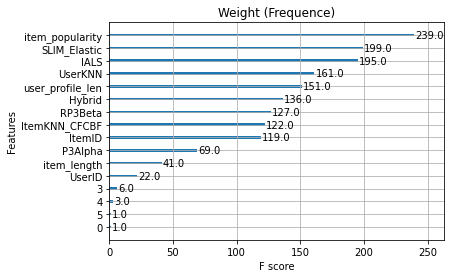

In [71]:
%matplotlib inline
from xgboost import plot_importance
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

#### Creating the dataframe with the predictions

In [73]:
user_recommendations_items = []
user_recommendations_user_id = []

for id in tqdm(target['id']):
    recommendations = hybrid.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))

100%|██████████| 41116/41116 [03:07<00:00, 219.53it/s]


In [74]:
test_dataframe = pd.DataFrame({"UserID":user_recommendations_user_id, "ItemID":user_recommendations_items})

In [75]:
ItemKNN_CFCBF_all = ItemKNN_CFCBF_Hybrid_Recommender(urm_all, icm_all)
ItemKNN_CFCBF_all.fit(**ItemKNN_CFCBF_params)

UserKNN_all = UserKNNCFRecommender(urm_all)
UserKNN_all.fit(**UserKNN_params)

P3Alpha_all = P3alphaRecommender(urm_all)
P3Alpha_all.fit(**P3Alpha_params)

other_algorithms_all = {
    "Hybrid": hybrid,
    "SLIM_Elastic": SLIM_Elastic,
    "RP3Beta": RP3Beta,
    "ItemKNN_CFCBF": ItemKNN_CFCBF_all,
    "UserKNN": UserKNN_all,
    "IALS": IALS,
    "P3Alpha": P3Alpha_all,
}

ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (19.9%) items with no features.
Similarity column 24507 (100.0%), 1541.45 column/sec. Elapsed time 15.90 sec
Similarity column 41629 (100.0%), 1368.73 column/sec. Elapsed time 30.41 sec
P3alphaRecommender: Similarity column 24507 (100.0%), 1872.07 column/sec. Elapsed time 13.09 sec


In [76]:
test_dataframe = test_dataframe.set_index('UserID')

for user_id in tqdm(target['id']):
    for rec_label, rec_instance in other_algorithms_all.items():
        
        item_list = test_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "UserID"})

100%|██████████| 41116/41116 [23:55<00:00, 28.64it/s]


In [77]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_all).indptr)
test_dataframe['item_popularity'] = item_popularity[test_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(urm_all).indptr)
test_dataframe['user_profile_len'] = user_popularity[test_dataframe["UserID"].values.astype(int)]

test_dataframe

,UserID,ItemID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len
0,0,88,0.830633,0.225797,0.197448,0.669624,2.989326,0.292406,0.040531,5016,66
1,0,99,0.690831,0.182744,0.163713,1.017144,11.227981,0.433097,0.079201,379,66
2,0,111,0.675813,0.227249,0.084482,0.591702,0.750476,0.323649,0.048149,648,66
3,0,108,0.652395,0.218284,0.085561,0.553165,1.113960,0.265340,0.049999,699,66
4,0,175,0.634387,0.214142,0.079379,0.351877,3.869202,0.272988,0.053071,1337,66
...,...,...,...,...,...,...,...,...,...,...,...
1439055,41628,2052,0.104105,0.030760,0.020511,0.095594,0.000000,0.040014,0.009292,92,23
1439056,41628,2262,0.101091,0.020391,0.037359,0.100870,0.890115,0.001790,0.010663,33,23
1439057,41628,1991,0.099060,0.026474,0.024137,0.134864,0.000000,0.038370,0.009319,66,23
1439058,41628,8589,0.098576,0.025593,0.027459,0.058114,0.680482,-0.008787,0.016671,241,23


In [78]:
features_df = pd.DataFrame.sparse.from_spmatrix(icm_all)

test_dataframe = test_dataframe.set_index('ItemID').join(features_df, how='inner')
test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "ItemID"})

test_dataframe = test_dataframe.merge(icm_length_mapped, how="left")
test_dataframe['item_length'] = test_dataframe['item_length'].fillna(0).astype(int)

test_dataframe = test_dataframe.sort_values("UserID").reset_index()
test_dataframe.drop(columns = ['index'], inplace=True)
test_dataframe

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length
0,376,0,0.520283,0.123536,0.147914,0.779760,3.814598,0.299219,0.059761,3727,66,0.0,0.0,0.0,0.0,0.0,0.0,0
1,4654,0,0.434871,0.141704,0.059958,0.400346,0.614666,0.249064,0.036078,240,66,1.0,0.0,0.0,0.0,0.0,1.0,1
2,275,0,0.361116,0.099264,0.068129,0.800018,3.382163,0.467273,0.056709,530,66,0.0,0.0,0.0,0.0,1.0,1.0,12
3,307,0,0.429680,0.095679,0.160084,0.213896,3.499082,-0.339785,0.000000,4165,66,0.0,0.0,0.0,1.0,0.0,1.0,1
4,3274,0,0.391014,0.128417,0.050899,0.573366,3.287755,0.252780,0.034715,304,66,0.0,0.0,0.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439055,2,41628,0.285531,0.093475,0.044597,0.291749,8.957223,0.036191,0.043864,6021,23,0.0,0.0,1.0,0.0,0.0,1.0,1
1439056,467,41628,0.110660,0.034066,0.020158,0.095976,0.763269,0.029185,0.012942,68,23,1.0,0.0,0.0,0.0,0.0,1.0,1
1439057,3872,41628,0.217115,0.042301,0.075872,0.317222,11.051651,0.150232,0.040379,135,23,1.0,0.0,0.0,0.0,0.0,1.0,3
1439058,12124,41628,0.189518,0.051274,0.048407,0.149008,1.285374,0.003488,0.017816,47,23,1.0,0.0,0.0,0.0,0.0,1.0,1


### Predicting

In [79]:
X = test_dataframe

In [80]:
predictions = XGB_model.predict(X)
predictions

array([-0.05360216, -0.59312624, -0.36723626, ..., -0.24623507,
       -1.4525205 , -1.5458456 ], dtype=float32)

### Reranking

In [81]:
reranked_dataframe = test_dataframe.copy()
reranked_dataframe['rating_xgb'] = pd.Series(predictions, index=reranked_dataframe.index)
reranked_dataframe

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length,rating_xgb
0,376,0,0.520283,0.123536,0.147914,0.779760,3.814598,0.299219,0.059761,3727,66,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.053602
1,4654,0,0.434871,0.141704,0.059958,0.400346,0.614666,0.249064,0.036078,240,66,1.0,0.0,0.0,0.0,0.0,1.0,1,-0.593126
2,275,0,0.361116,0.099264,0.068129,0.800018,3.382163,0.467273,0.056709,530,66,0.0,0.0,0.0,0.0,1.0,1.0,12,-0.367236
3,307,0,0.429680,0.095679,0.160084,0.213896,3.499082,-0.339785,0.000000,4165,66,0.0,0.0,0.0,1.0,0.0,1.0,1,-0.271425
4,3274,0,0.391014,0.128417,0.050899,0.573366,3.287755,0.252780,0.034715,304,66,0.0,0.0,0.0,1.0,0.0,1.0,1,-0.528264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439055,2,41628,0.285531,0.093475,0.044597,0.291749,8.957223,0.036191,0.043864,6021,23,0.0,0.0,1.0,0.0,0.0,1.0,1,0.256834
1439056,467,41628,0.110660,0.034066,0.020158,0.095976,0.763269,0.029185,0.012942,68,23,1.0,0.0,0.0,0.0,0.0,1.0,1,-2.795848
1439057,3872,41628,0.217115,0.042301,0.075872,0.317222,11.051651,0.150232,0.040379,135,23,1.0,0.0,0.0,0.0,0.0,1.0,3,-0.246235
1439058,12124,41628,0.189518,0.051274,0.048407,0.149008,1.285374,0.003488,0.017816,47,23,1.0,0.0,0.0,0.0,0.0,1.0,1,-1.452520


In [82]:
reranked_dataframe = reranked_dataframe.sort_values(['UserID','rating_xgb'], ascending=[True, False])
reranked_dataframe

,ItemID,UserID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,UserKNN,IALS,P3Alpha,item_popularity,user_profile_len,0,1,2,3,4,5,item_length,rating_xgb
33,88,0,0.830633,0.225797,0.197448,0.669624,2.989326,0.292406,0.040531,5016,66,0.0,0.0,0.0,0.0,1.0,1.0,14,0.539729
29,99,0,0.690831,0.182744,0.163713,1.017144,11.227981,0.433097,0.079201,379,66,1.0,0.0,0.0,0.0,0.0,1.0,1,0.492176
31,111,0,0.675813,0.227249,0.084482,0.591702,0.750476,0.323649,0.048149,648,66,0.0,0.0,0.0,0.0,1.0,1.0,8,0.325554
18,1966,0,0.535334,0.160961,0.085965,0.930306,5.828948,0.524607,0.059382,468,66,1.0,0.0,0.0,0.0,0.0,1.0,2,0.274469
27,108,0,0.652395,0.218284,0.085561,0.553165,1.113960,0.265340,0.049999,699,66,1.0,0.0,0.0,0.0,0.0,1.0,1,0.240500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439029,2052,41628,0.104105,0.030760,0.020511,0.095594,0.000000,0.040014,0.009292,92,23,0.0,0.0,0.0,0.0,1.0,1.0,26,-3.048265
1439030,1991,41628,0.099060,0.026474,0.024137,0.134864,0.000000,0.038370,0.009319,66,23,0.0,0.0,0.0,0.0,1.0,1.0,22,-3.120248
1439041,8589,41628,0.098576,0.025593,0.027459,0.058114,0.680482,-0.008787,0.016671,241,23,1.0,0.0,0.0,0.0,0.0,1.0,1,-3.146088
1439048,2042,41628,0.111152,0.032765,0.022698,0.110710,0.000000,0.028375,0.008008,58,23,0.0,0.0,0.0,0.0,0.0,0.0,0,-3.277876


# Submission

In [83]:
def write_reranked_recommendations(file_name):
    recommendations = 'user_id,item_list'
    f = open(file_name + ".csv", "w")

    for id in tqdm(target['id']):
        recommendations_per_user = reranked_dataframe.loc[reranked_dataframe['UserID'] == id].ItemID.values[:10]

        recommendation_string = str(user_original_ID_to_index[user_original_ID_to_index==id].index.item()
                                    ) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(item_original_ID_to_index[item_original_ID_to_index==rec].index.item()) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [84]:
write_reranked_recommendations(file_name = "submission")

100%|██████████| 41116/41116 [04:15<00:00, 160.84it/s]


In [85]:
submission = pd.read_csv("submission.csv")
submission

,user_id,item_list
0,0,20 391 752 2488 617 2495 56 18484 29 23
1,1,6874 56 665 62 21 124 352 61 393 1068
2,2,121 7864 925 22415 1308 453 750 1311 8819 21319
3,3,20 21 7113 352 917 269 16263 557 169 22752
4,4,23 80 21 68 124 64 56 541 436 2119
...,...,...
41111,41624,11552 22403 10221 7864 617 15711 13472 752 150...
41112,41625,53 23 56 393 60 25 598 268 450 395
41113,41626,21 387 270 61 23 598 20 58 22619 25
41114,41627,1214 1754 17021 2803 8655 4577 1558 1859 1561 ...


<hr>

## Sanity check

In [86]:
result_hybrid, _ = evaluator_test.evaluateRecommender(hybrid_train)
result_elastic, _ = evaluator_test.evaluateRecommender(SLIM_Elastic_train)
result_rp3b, _ = evaluator_test.evaluateRecommender(RP3Beta_train)
result_ials, _ = evaluator_test.evaluateRecommender(IALS_train)
result_itemKnn, _ = evaluator_test.evaluateRecommender(ItemKNN_CFCBF_train)
result_userKnn, _ = evaluator_test.evaluateRecommender(UserKNN_train)
result_p3a, _ = evaluator_test.evaluateRecommender(P3Alpha_train)


print("Hybrid: {}".format(result_hybrid['MAP'].item()))
print("SLIM Elastic: {}".format(result_elastic['MAP'].item()))
print("RP3Beta: {}".format(result_rp3b['MAP'].item()))
print("IALS: {}".format(result_ials['MAP'].item()))
print("ItemKNN_CFCBF: {}".format(result_itemKnn['MAP'].item()))
print("UserKNN: {}".format(result_userKnn['MAP'].item()))
print("P3Alpha: {}".format(result_p3a['MAP'].item()))

EvaluatorHoldout: Processed 40653 (100.0%) in 1.14 min. Users per second: 593
EvaluatorHoldout: Processed 40653 (100.0%) in 46.39 sec. Users per second: 876
EvaluatorHoldout: Processed 40653 (100.0%) in 31.18 sec. Users per second: 1304
EvaluatorHoldout: Processed 40653 (100.0%) in 39.66 sec. Users per second: 1025
EvaluatorHoldout: Processed 40653 (100.0%) in 32.02 sec. Users per second: 1270
EvaluatorHoldout: Processed 40653 (100.0%) in 52.40 sec. Users per second: 776
EvaluatorHoldout: Processed 40653 (100.0%) in 31.68 sec. Users per second: 1283
Hybrid: 0.028315770834772
SLIM Elastic: 0.028054034747820096
RP3Beta: 0.025883070969595252
IALS: 0.020087014996061903
ItemKNN_CFCBF: 0.02463771978014404
UserKNN: 0.024393476886650327
P3Alpha: 0.02393646635344602


## Stats

In [87]:
noreranksubmission = pd.read_csv("submission_norerank.csv")

In [88]:
changed_item_count = 0

for user_id in submission['user_id']:
    default_items = noreranksubmission[noreranksubmission['user_id'] == user_id].item_list.values[0].split()
    reranked_items = submission[submission['user_id'] == user_id].item_list.values[0].split()
    
    new_items = list(set(reranked_items) - set(default_items))
    
    changed_item_count = changed_item_count + len(new_items)
    
n_users_to_recommend = len(target['id'])
n_recommended_items = n_users_to_recommend * 10

print("Changed {} items, {:.2f}% of total".format(changed_item_count, changed_item_count/n_recommended_items * 100))

Changed 83705 items, 20.36% of total


## Save models

In [90]:
SLIM_Elastic.save_model("used_models", "SLIM_Elastic_all.zip")
SLIM_Elastic_train.save_model("used_models", "SLIM_Elastic_train_validation.zip")

RP3Beta.save_model("used_models", "RP3Beta_all.zip")
RP3Beta_train.save_model("used_models", "RP3Beta_train_validation.zip")

IALS.save_model("used_models", "IALS_all.zip")
IALS_train.save_model("used_models", "IALS_train_validation.zip")

SLIMElasticNetRecommender: Saving model in file 'used_modelsSLIM_Elastic_all.zip'
SLIMElasticNetRecommender: Saving complete
SLIMElasticNetRecommender: Saving model in file 'used_modelsSLIM_Elastic_train_validation.zip'
SLIMElasticNetRecommender: Saving complete
RP3betaRecommender: Saving model in file 'used_modelsRP3Beta_all.zip'
RP3betaRecommender: Saving complete
RP3betaRecommender: Saving model in file 'used_modelsRP3Beta_train_validation.zip'
RP3betaRecommender: Saving complete
IALSRecommender: Saving model in file 'used_modelsIALS_all.zip'
IALSRecommender: Saving complete
IALSRecommender: Saving model in file 'used_modelsIALS_train_validation.zip'
IALSRecommender: Saving complete


In [91]:
!mkdir ../data
!cp used_models/* ../data
!cp submission.csv ..
!cp submission_norerank.csv ..

In [94]:
os.chdir("..")
!rm -r RecSys-2022-Challenge-Polimi

In [95]:
training_dataframe.to_csv("training_dataframe.csv")
test_dataframe.to_csv("test_dataframe.csv")